In [1]:
%%configure
{"vCores": 8 }

In [2]:
!pip install  -q pyspark-client
!pip install  -q pysail
notebookutils.session.restartPython()

sys.exit called with value 0. The interpreter will be restarted.


In [3]:
SF         =  100
ws         = 'tpch'
lh         = 'data'
results    = 'abfss://sqlengines@onelake.dfs.fabric.microsoft.com/benchmarks.Lakehouse/Tables/dbo/result'

In [4]:
import os
os.environ["SAIL_SPARK__SESSION_TIMEOUT_SECS"]          = "3600"
os.environ["SAIL_EXECUTION__FILE_LISTING_CACHE__TYPE"]  = "global"
os.environ["SAIL_PARQUET__FILE_STATISTICS_CACHE__TYPE"] = "global"
os.environ["SAIL_PARQUET__REORDER_FILTERS"]             = "true"
os.environ["SAIL_RUNTIME__ENABLE_SECONDARY"]            = "true"

In [5]:
import pandas             as pd
from   datetime           import datetime
from   pysail.spark       import SparkConnectServer
from   pyspark.sql        import SparkSession
from   psutil             import *
import time

# Generate Data

In [6]:
%%time
import pathlib
schema = f'CH{SF:04d}'
tpch_tables = ['nation','region','customer','supplier','lineitem','orders','partsupp','part']
Table_Path = '/lakehouse/default/Tables'
lineitem_parts = max(2, int(200 * (SF / 1000)))
orders_parts   = max(2, int(140 * (SF / 1000)))
partsupp_parts = max(1, int(80 * (SF / 1000)))
part_parts     = max(1, int(12 * (SF / 1000)))
customer_parts = max(1, int(20 * (SF / 1000)))
BASE_OUTPUT_DIR = f"/lakehouse/default/Tables/{schema}"

shell_script = f"""
set -e

SCALE_FACTOR={SF}
BASE_OUTPUT_DIR="{BASE_OUTPUT_DIR}"
declare -A TABLES_PARTS=(
    ["lineitem"]={lineitem_parts}
    ["orders"]={orders_parts}
    ["partsupp"]={partsupp_parts}
    ["part"]={part_parts}
    ["customer"]={customer_parts}
    ["nation"]=1
    ["region"]=1
    ["supplier"]=1
)
echo "--- Starting TPC-H Data Generation ---"
echo "Scale Factor: ${{SCALE_FACTOR}}"
echo "Base Output Directory: ${{BASE_OUTPUT_DIR}}"
echo ""

for table_name in "${{!TABLES_PARTS[@]}}"; do
    num_parts_to_generate="${{TABLES_PARTS[${{table_name}}]}}"
    echo "--- Generating data for table: ${{table_name}} (${{num_parts_to_generate}} parts) ---"
    echo "  -> Generating ${{table_name}} part ${{i}}/${{num_parts_to_generate}} "
        tpchgen-cli \\
            -s "${{SCALE_FACTOR}}" \\
            --tables "${{table_name}}" \\
            --output-dir "${{BASE_OUTPUT_DIR}}" \\
            --parts "${{num_parts_to_generate}}" \\
            --format="parquet" \\
            --parquet-row-group-bytes=268435456
    done
    echo "--- Finished generating data for table: ${{table_name}} ---"
echo "--- TPC-H Data Generation Complete! ---"
"""
if not pathlib.Path(f'{Table_Path}/{schema}').exists():
    !pip install -q tpchgen-cli
    !pip install deltalake
    from   deltalake  import convert_to_deltalake
    print('generate new data')
    get_ipython().system(shell_script)
    for tbl in tpch_tables:
      convert_to_deltalake(f'{BASE_OUTPUT_DIR}/{tbl}',storage_options={"allow_unsafe_rename":"true"})

CPU times: user 3.2 ms, sys: 0 ns, total: 3.2 ms
Wall time: 567 ms


In [7]:
core = cpu_count()
vCPU = str(core) + " vCPU"
mem=round(virtual_memory().total/(1024 * 1024 * 1024),0)
core

8

# SQL Query

In [8]:
# @title
sql=(f'''
SELECT
    --Query01
    l_returnflag,
    l_linestatus,
    SUM(l_quantity) AS sum_qty,
    SUM(l_extendedprice) AS sum_base_price,
    SUM(l_extendedprice * (1 - l_discount)) AS sum_disc_price,
    SUM(l_extendedprice * (1 - l_discount) * (1 + l_tax)) AS sum_charge,
    AVG(l_quantity) AS avg_qty,
    AVG(l_extendedprice) AS avg_price,
    AVG(l_discount) AS avg_disc,
    COUNT(*) AS count_order
FROM
    lineitem
WHERE
    l_shipdate <= CAST('1998-09-02' AS date)
GROUP BY
    l_returnflag,
    l_linestatus
ORDER BY
    l_returnflag,
    l_linestatus;



WITH cheapest_part AS (
    SELECT
        MIN(ps.ps_supplycost) AS cp_lowest,
        p.p_partkey AS cp_partkey
    FROM part p
    JOIN partsupp ps ON p.p_partkey = ps.ps_partkey
    JOIN supplier s ON s.s_suppkey = ps.ps_suppkey
    JOIN nation n ON s.s_nationkey = n.n_nationkey
    JOIN region r ON n.n_regionkey = r.r_regionkey
    WHERE r.r_name = 'EUROPE'
    GROUP BY p.p_partkey
)
SELECT
    s.s_acctbal,
    s.s_name,
    n.n_name,
    p.p_partkey,
    p.p_mfgr,
    s.s_address,
    s.s_phone,
    s.s_comment
FROM part p
JOIN partsupp ps ON p.p_partkey = ps.ps_partkey
JOIN supplier s ON s.s_suppkey = ps.ps_suppkey
JOIN nation n ON s.s_nationkey = n.n_nationkey
JOIN region r ON n.n_regionkey = r.r_regionkey
JOIN cheapest_part cp ON ps.ps_supplycost = cp.cp_lowest AND cp.cp_partkey = p.p_partkey
WHERE p.p_size = 15
  AND p.p_type LIKE '%BRASS'
  AND r.r_name = 'EUROPE'
ORDER BY s.s_acctbal DESC,
         n.n_name,
         s.s_name,
         p.p_partkey
LIMIT 10;









SELECT
    l.l_orderkey,
    SUM(l.l_extendedprice * (1 - l.l_discount)) AS revenue,
    o.o_orderdate,
    o.o_shippriority
FROM
    customer c
JOIN orders o ON c.c_custkey = o.o_custkey
JOIN lineitem l ON l.l_orderkey = o.o_orderkey
WHERE
    c.c_mktsegment = 'BUILDING'
    AND o.o_orderdate < CAST('1995-03-15' AS DATE)
    AND l.l_shipdate > CAST('1995-03-15' AS DATE)
GROUP BY
    l.l_orderkey,
    o.o_orderdate,
    o.o_shippriority
ORDER BY
    revenue DESC,
    o.o_orderdate
LIMIT 10;









select
--Query04
	o_orderpriority,
	count(*) as order_count
from
	orders
where
	o_orderdate >= cast('1993-07-01' as date)
	and o_orderdate < cast('1993-10-01' as date)
	and o_orderkey in (
		select
			l_orderkey
		from
			lineitem
		where
			l_commitdate < l_receiptdate
	)
group by
	o_orderpriority
order by
	o_orderpriority;




SELECT
    --Query05
    n_name,
    SUM(l_extendedprice * (1 - l_discount)) AS revenue
FROM lineitem
inner join (select * from orders where o_orderdate >= '1994-01-01' AND o_orderdate < '1995-01-01') as x
on l_orderkey = x.o_orderkey
left join supplier
on l_suppkey = s_suppkey
left join customer
on o_custkey = c_custkey and
c_nationkey = s_nationkey
left join nation
on s_nationkey = n_nationkey
inner join ( select * from region where r_name = 'ASIA') as xx
on n_regionkey = xx.r_regionkey

GROUP BY
    n_name
ORDER BY
    revenue DESC;


SELECT
    --Query06
    SUM(l_extendedprice * l_discount) AS revenue
FROM
    lineitem
WHERE
    l_shipdate >= CAST('1994-01-01' AS date)
    AND l_shipdate < CAST('1995-01-01' AS date)
    AND l_discount BETWEEN 0.05
    AND 0.07
    AND l_quantity < 24;







SELECT
    --Query07
    supp_nation,
    cust_nation,
    l_year,
    SUM(volume) AS revenue
FROM (
    SELECT
        n1.n_name AS supp_nation,
        n2.n_name AS cust_nation,
        EXTRACT(YEAR FROM l.l_shipdate) AS l_year,
        l.l_extendedprice * (1 - l.l_discount) AS volume
    FROM
        supplier s
    JOIN lineitem l ON s.s_suppkey = l.l_suppkey
    JOIN orders o ON o.o_orderkey = l.l_orderkey
    JOIN customer c ON c.c_custkey = o.o_custkey
    JOIN nation n1 ON s.s_nationkey = n1.n_nationkey
    JOIN nation n2 ON c.c_nationkey = n2.n_nationkey
    WHERE
        (n1.n_name = 'FRANCE' AND n2.n_name = 'GERMANY')
        OR (n1.n_name = 'GERMANY' AND n2.n_name = 'FRANCE')
        AND l.l_shipdate BETWEEN CAST('1995-01-01' AS DATE) AND CAST('1996-12-31' AS DATE)
) AS shipping
GROUP BY
    supp_nation,
    cust_nation,
    l_year
ORDER BY
    supp_nation,
    cust_nation,
    l_year;








SELECT
    --Query08
        EXTRACT( year  FROM  o_orderdate ) AS o_year,
        SUM(  CASE  WHEN n2.n_name = 'BRAZIL' THEN l_extendedprice * (1 - l_discount) ELSE 0  END ) / SUM(l_extendedprice * (1 - l_discount)) AS mkt_share
        FROM  lineitem
        inner join   (select o_custkey,o_orderdate, o_orderkey from  orders WHERE  o_orderdate BETWEEN CAST('1995-01-01' AS date) AND CAST('1996-12-31' AS date) ) xxx
        on l_orderkey = xxx.o_orderkey
        inner join  (select p_partkey from  part  where p_type = 'ECONOMY ANODIZED STEEL' ) z
        on  l_partkey = z.p_partkey
        left join    supplier
        on  l_suppkey = s_suppkey
        left join   customer
        on o_custkey = c_custkey
        left join   nation n1
        on c_nationkey = n1.n_nationkey
        left join   nation n2
        on s_nationkey = n2.n_nationkey
        inner join  (select * from region where r_name = 'AMERICA') cc
        on  n1.n_regionkey = cc.r_regionkey




GROUP BY
    o_year
ORDER BY
    o_year;










SELECT
    --Query09
    n_name AS nation,
    EXTRACT( year  FROM o_orderdate ) AS o_year,
    sum(l_extendedprice * (1 - l_discount) - ps_supplycost * l_quantity) AS sum_profit
        FROM lineitem
        inner join ( select p_partkey from part where  p_name LIKE '%green%') xx
        on  l_partkey = xx.p_partkey
        left join orders
        on  l_orderkey =o_orderkey
        left join  partsupp
        on  l_suppkey =ps_suppkey  AND  l_partkey = ps_partkey
        left join  supplier
        on    l_suppkey =s_suppkey
        left join nation
        on  n_nationkey = s_nationkey


GROUP BY
    n_name,
    o_year
ORDER BY
    n_name,
    o_year DESC;



SELECT
    --Query10
    c_custkey,
    c_name,
    SUM(l_extendedprice * (1 - l_discount)) AS revenue,
    c_acctbal,
    n_name,
    c_address,
    c_phone,
    c_comment
FROM  lineitem
inner join ( select * from orders where o_orderdate >= '1993-10-01' AND o_orderdate < '1994-01-01') as xx
on l_orderkey = xx.o_orderkey
left join customer
on xx.o_custkey = c_custkey
left join nation
on c_nationkey = n_nationkey
WHERE  l_returnflag = 'R'

GROUP BY
    c_custkey,
    c_name,
    c_acctbal,
    c_phone,
    n_name,
    c_address,
    c_comment
ORDER BY
    revenue DESC
LIMIT
    20;







SELECT
    ps.ps_partkey,
    SUM(ps.ps_supplycost * ps.ps_availqty) AS value
FROM
    partsupp ps
JOIN supplier s ON ps.ps_suppkey = s.s_suppkey
JOIN nation n ON s.s_nationkey = n.n_nationkey
WHERE
    n.n_name = 'GERMANY'
GROUP BY
    ps.ps_partkey
HAVING
    SUM(ps.ps_supplycost * ps.ps_availqty) > (
        SELECT
            SUM(ps_inner.ps_supplycost * ps_inner.ps_availqty) * (0.0001 / {SF})
        FROM
            partsupp ps_inner
        JOIN supplier s_inner ON ps_inner.ps_suppkey = s_inner.s_suppkey
        JOIN nation n_inner ON s_inner.s_nationkey = n_inner.n_nationkey
        WHERE
            n_inner.n_name = 'GERMANY'
    )
ORDER BY
    value DESC;









SELECT
    --Query12
    l_shipmode,
    SUM(
        CASE
            WHEN o_orderpriority = '1-URGENT'
            OR o_orderpriority = '2-HIGH' THEN 1
            ELSE 0
        END
    ) AS high_line_count,
    SUM(
        CASE
            WHEN o_orderpriority <> '1-URGENT'
            AND o_orderpriority <> '2-HIGH' THEN 1
            ELSE 0
        END
    ) AS low_line_count
FROM lineitem
left join  orders
on o_orderkey = l_orderkey

WHERE  l_shipmode IN ('MAIL', 'SHIP')
       AND l_commitdate < l_receiptdate
       AND l_shipdate < l_commitdate
       AND l_receiptdate >=  '1994-01-01'  AND l_receiptdate < '1995-01-01'
GROUP BY
    l_shipmode
ORDER BY
    l_shipmode;








SELECT
    --Query13
    c_count,
    COUNT(*) AS custdist
FROM
    (
        SELECT
            c_custkey,
            COUNT(o_orderkey) AS c_count
        FROM
            customer
            LEFT OUTER JOIN orders ON c_custkey = o_custkey
            AND o_comment NOT LIKE '%special%requests%'
        GROUP BY
            c_custkey
    ) AS c_orders
GROUP BY
    c_count
ORDER BY
    custdist DESC,
    c_count DESC;








SELECT
    --Query14
    100.00 * SUM(
        CASE
            WHEN p_type LIKE 'PROMO%' THEN l_extendedprice * (1 - l_discount)
            ELSE 0
        END
    ) / SUM(l_extendedprice * (1 - l_discount)) AS promo_revenue
FROM  lineitem
left join part
on l_partkey = p_partkey
WHERE l_shipdate >= cast('1995-09-01' as date) AND l_shipdate < cast('1995-10-01' as date);








SELECT
    --Query15
    s_suppkey,
    s_name,
    s_address,
    s_phone,
    total_revenue
FROM
    supplier,
    (
        SELECT
            l_suppkey AS supplier_no,
            SUM(l_extendedprice * (1 - l_discount)) AS total_revenue
        FROM
            lineitem
        WHERE
            l_shipdate >= CAST('1996-01-01' AS date)
            AND l_shipdate < CAST('1996-04-01' AS date)
        GROUP BY
            l_suppkey
    ) revenue0
WHERE
    s_suppkey = supplier_no
    AND total_revenue = (
        SELECT
            MAX(total_revenue)
        FROM
            (
                SELECT
                    l_suppkey AS supplier_no,
                    SUM(l_extendedprice * (1 - l_discount)) AS total_revenue
                FROM
                    lineitem
                WHERE
                    l_shipdate >= CAST('1996-01-01' AS date)
                    AND l_shipdate < CAST('1996-04-01' AS date)
                GROUP BY
                    l_suppkey
            ) revenue1
    )
ORDER BY
    s_suppkey;








SELECT
    --Query16
    p.p_brand,
    p.p_type,
    p.p_size,
    COUNT(DISTINCT ps.ps_suppkey) AS supplier_cnt
FROM
    partsupp ps
JOIN part p ON p.p_partkey = ps.ps_partkey
WHERE
    p.p_brand <> 'Brand#45'
    AND p.p_type NOT LIKE 'MEDIUM POLISHED%'
    AND p.p_size IN (49, 14, 23, 45, 19, 3, 36, 9)
    AND ps.ps_suppkey NOT IN (
        SELECT
            s.s_suppkey
        FROM
            supplier s
        WHERE
            s.s_comment LIKE '%Customer%Complaints%'
    )
GROUP BY
    p.p_brand,
    p.p_type,
    p.p_size
ORDER BY
    supplier_cnt DESC,
    p.p_brand,
    p.p_type,
    p.p_size;









WITH part_avg AS (
    -- Query17
    SELECT
        (0.2 * AVG(l.l_quantity)) AS limit_qty,
        l.l_partkey AS lpk
    FROM lineitem l
    GROUP BY l.l_partkey
)
SELECT
    SUM(l.l_extendedprice) / 7.0 AS avg_yearly
FROM
    lineitem l
JOIN part p ON p.p_partkey = l.l_partkey
JOIN part_avg pa ON p.p_partkey = pa.lpk
WHERE
    p.p_brand = 'Brand#23'
    AND p.p_container = 'MED BOX'
    AND l.l_quantity < pa.limit_qty;







SELECT
    --Query18
    c.c_name,
    c.c_custkey,
    o.o_orderkey,
    o.o_orderdate,
    o.o_totalprice,
    SUM(l.l_quantity)
FROM
    customer c
JOIN orders o ON c.c_custkey = o.o_custkey
JOIN lineitem l ON o.o_orderkey = l.l_orderkey
WHERE
    o.o_orderkey IN (
        SELECT
            l_orderkey
        FROM
            lineitem
        GROUP BY
            l_orderkey
        HAVING
            SUM(l_quantity) > 300
    )
GROUP BY
    c.c_name,
    c.c_custkey,
    o.o_orderkey,
    o.o_orderdate,
    o.o_totalprice
ORDER BY
    o.o_totalprice DESC,
    o.o_orderdate
LIMIT
    100;






select
--Query19
sum(l_extendedprice* (1 - l_discount)) as revenue

from lineitem
join  part
ON p_partkey = l_partkey
where (
		p_brand = 'Brand#12'
		and p_container in ('SM CASE', 'SM BOX', 'SM PACK', 'SM PKG')
		and l_quantity >= 1 and l_quantity <= 1 + 10
		and p_size between 1 and 5
		and l_shipmode in ('AIR', 'AIR REG')
		and l_shipinstruct = 'DELIVER IN PERSON'
	) or ( p_partkey = l_partkey
		and p_brand = 'Brand#23'
		and p_container in ('MED BAG', 'MED BOX', 'MED PKG', 'MED PACK')
		and l_quantity >= 10 and l_quantity <= 10 + 10
		and p_size between 1 and 10
		and l_shipmode in ('AIR', 'AIR REG')
		and l_shipinstruct = 'DELIVER IN PERSON'
	) or ( p_partkey = l_partkey
		and p_brand = 'Brand#34'
		and p_container in ('LG CASE', 'LG BOX', 'LG PACK', 'LG PKG')
		and l_quantity >= 20 and l_quantity <= 20 + 10
		and p_size between 1 and 15
		and l_shipmode in ('AIR', 'AIR REG')
		and l_shipinstruct = 'DELIVER IN PERSON'
	);





--Query20
with availability_part_supp as(
	    select 0.5 * sum(l_quantity) as ps_halfqty, l_partkey as pkey, l_suppkey as skey
	    from lineitem
	    where l_shipdate >= cast('1994-01-01' as date)
	    and l_shipdate < cast('1995-01-01' as date)
	    group by pkey, skey
)
select s_name, s_address
from supplier, nation
where s_suppkey in (
	    select ps_suppkey
	    from partsupp, availability_part_supp
	    where ps_partkey in (
		        select p_partkey
			        from part
				        where p_name like 'forest%'
					    )
					    and ps_partkey = pkey
					    and ps_suppkey = skey
					    and ps_availqty > ps_halfqty
				)
				and s_nationkey = n_nationkey
				and n_name = 'CANADA'
				order by s_name;






SELECT
    --Query21
    s.s_name,
    COUNT(*) AS numwait
FROM
    supplier s
JOIN lineitem l1 ON s.s_suppkey = l1.l_suppkey
JOIN orders o ON o.o_orderkey = l1.l_orderkey
JOIN nation n ON s.s_nationkey = n.n_nationkey
WHERE
    o.o_orderstatus = 'F'
    AND l1.l_receiptdate > l1.l_commitdate
    AND l1.l_orderkey IN (
        SELECT l_orderkey
        FROM lineitem
        GROUP BY l_orderkey
        HAVING COUNT(l_suppkey) > 1
    )
    AND l1.l_orderkey NOT IN (
        SELECT l_orderkey
        FROM lineitem
        WHERE l_receiptdate > l_commitdate
        GROUP BY l_orderkey
        HAVING COUNT(l_suppkey) > 1
    )
    AND n.n_name = 'SAUDI ARABIA'
GROUP BY s.s_name
ORDER BY numwait DESC, s.s_name
LIMIT 100;





select
--Query22
cntrycode,
	count(*) as numcust,
	sum(c_acctbal) as totacctbal
from ( select
			substring(c_phone from 1 for 2) as cntrycode,
			c_acctbal
		from customer
		where substring(c_phone from 1 for 2) in
				('13', '31', '23', '29', '30', '18', '17')
			and c_acctbal > (
				select avg(c_acctbal)
				from customer
				where c_acctbal > 0
					and substring(c_phone from 1 for 2) in
						('13', '31', '23', '29', '30', '18', '17')
			)
			and c_custkey not in (
				select o_custkey
				from orders
			)
	) as custsale
group by cntrycode
order by cntrycode;

''')

In [9]:
def execute_query(engine, sql_script, excluse_list):
    results = []  # Collect data in a list first
    sql_arr = sql_script.split(";")
    
    for index, value in enumerate(sql_arr, start=1):
        if index not in excluse_list:
            if len(value.strip()) > 0:
                start = time.time()
                print('query' + str(index))
                try:
                    print(engine.sql(value).toPandas())
                    stop = time.time()
                    duration = stop - start
                except Exception as er:
                    print(er)
                    duration = float('nan')
                print(duration)
                results.append({'dur': duration, 'query': index})
    
    # Create DataFrame once at the end
    return pd.DataFrame(results) if results else pd.DataFrame(columns=['dur', 'query'])

In [10]:
print(schema)

CH0100


In [11]:
%%time
server = SparkConnectServer()
server.start()
_, port = server.listening_address
start = time.time()
spark = SparkSession.builder.remote(f"sc://localhost:{port}").getOrCreate()
for tbl in tpch_tables :
     spark.sql(f""" create table {tbl} using delta location '/lakehouse/default/Tables/{schema}/{tbl}' """)
stop                    =  time.time()
df                      =  execute_query(spark, sql,[])
df.at[0,'dur']          =  df.at[0, 'dur'] + (stop-start)
df['Engine']            =  'lakesail'
df['time']              =  datetime.now().strftime('%Y-%m-%d %H:%M:%S')
df['sf']                =  SF
df['cpu']               =  core
df['test']              = 'tpch'
spark.createDataFrame(df).write.format("delta").mode("append").save(results)

query1
  l_returnflag l_linestatus        sum_qty     sum_base_price  \
0            A            F  3775127758.00   5660776097194.45   
1            N            F    98553062.00    147771098385.98   
2            N            O  7436302976.00  11150725681373.59   
3            R            F  3775724970.00   5661603032745.34   

        sum_disc_price             sum_charge    avg_qty     avg_price  \
0   5377736398183.9374   5592847429515.927026  25.499370  38236.116984   
1    140384965965.0348    145999793032.775829  25.501556  38237.199388   
2  10593195308234.8523  11016932248183.655467  25.500009  38237.227646   
3   5378513563915.4097   5593662252666.916161  25.500066  38236.697258   

   avg_disc  count_order  
0  0.050002    148047881  
1  0.049985      3864590  
2  0.049997    291619617  
3  0.050001    148067261  
39.89151477813721
query2
  s_acctbal              s_name          n_name  p_partkey          p_mfgr  \
0   9999.70  Supplier#000239544  UNITED KINGDOM    6739531

# Results

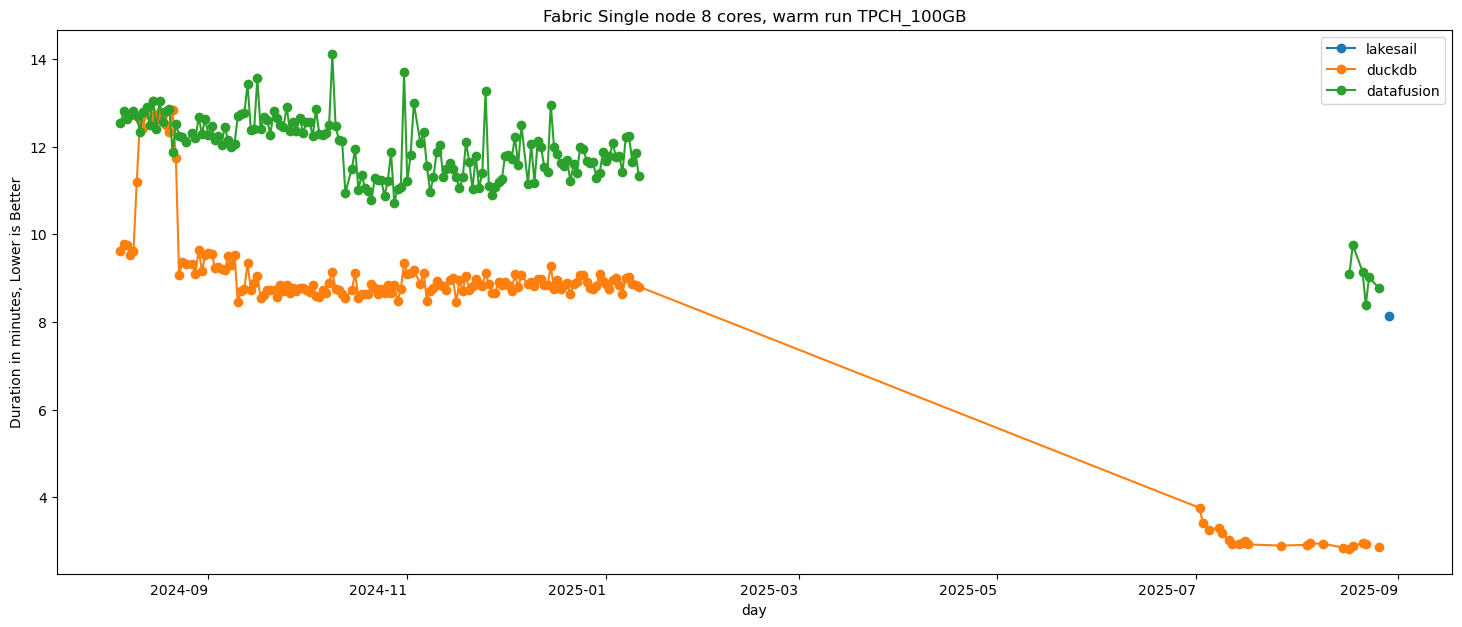

In [12]:
spark.sql(f""" create table if not exists dt using delta location '{results}' """)
ff = spark.sql(f""" 
   with raw as (
       select time,query,sf,cpu as core,Engine, dur
       from dt
       where test = 'tpch' and Engine in ('lakesail','duckdb','datafusion')  and sf = {SF} and cpu = {core}
   ),
   xxx as (
       select time,sf,core,Engine, sum(dur) as duration from raw group by 1,2,3,4
   ),
   daily as (
       select date_trunc('day', CAST(time AS TIMESTAMP)) AS day,sf,core,Engine,avg(duration)/60 as duration from xxx group by 1,2,3,4
   )
   select day,
          avg(case when Engine = 'lakesail' then duration end)   as lakesail,
          avg(case when Engine = 'duckdb' then duration end)     as duckdb,
          avg(case when Engine = 'datafusion' then duration end) as datafusion
   from daily
   group by day
   order by day
""").toPandas()
# Create the line plot with separate lines for each engine
ax = ff.plot.line(
    rot=0,
    x='day',
    title=F"Fabric Single node {core} cores, warm run TPCH_{SF}GB",
    ylabel='Duration in minutes, Lower is Better',
    marker ='o',
    figsize=(18, 8)
)